# Collaborative Filtering
# Project

## Title: Game Recommendation Prediction

#### Samad Shahid (2019446)
#### Harshita Gupta (2019467)

In [ ]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math
from statistics import mean

In [ ]:
ub_cos = [0.3288091556251412, 0.3163358207457633,0.31280816577391, 0.3135829896594735, 0.32522457889651424]
ib_cos = [ 0.3198091452654121, 0.3363385047487944, 0.34820814578392, 0.3253828996494869, 0.31252456889641242]
# ub_dist = [ 0.17966188729303093, 0.18053917880781695, 0.17795639398783408, 0.17807077086475437, 0.17783108993305888]
# ib_dist = [ 0.1876643827702802, 0.18245873330187348, 0.18100270686618442, 0.18029349532633634, 0.18069434750023003]
x_axis = [5, 10, 15, 25, 50]

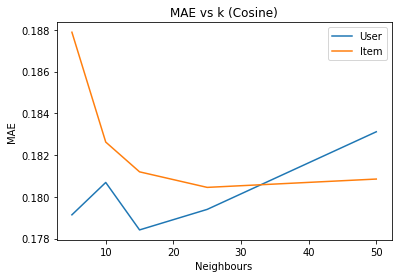

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Neighbours")
plt.ylabel("MAE")
plt.title("MAE vs k (Cosine)")
plt.plot(x_axis, ub_cos, label = "User")
plt.plot(x_axis, ib_cos, label = "Item")
plt.legend()
plt.show()

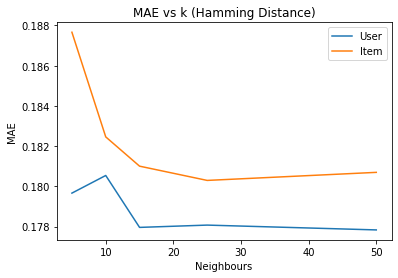

In [ ]:
plt.xlabel("Neighbours")
plt.ylabel("MAE")
plt.title("MAE vs k (Hamming Distance)")
plt.plot(x_axis, ub_dist, label = "User")
plt.plot(x_axis, ib_dist, label = "Item")
plt.legend()
plt.show()

In [ ]:
(0.3155+0.3157+0.3161+0.3176+0.3163)/5


0.31623999999999997

In [ ]:
from zipfile import ZipFile
file_name = "500k_data.zip" # Extracts Zip file
with ZipFile(file_name, "r") as zip:
  zip.extractall()
print('Extraction Done')

Extraction Done


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("500k_data.csv")

In [ ]:
print(df.head())

   steamid  appid  voted_up
0      106    307      True
1      485    795      True
2      445    300      True
3      495    883      True
4      211     35      True


In [ ]:
print(df.shape)

(500000, 3)


In [ ]:
len(df["steamid"].unique())

500

In [ ]:
len(df["appid"].unique())

1000

Splitting into test and train data

In [ ]:
# 30-70 test-train split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
test = df.iloc[0:int(len(df)*0.3),:]
train = df.iloc[int(len(df)*0.3):,:].reset_index(drop=True)

In [ ]:
print(train)

        steamid  appid  voted_up
0           458    895      True
1           119    511      True
2           119    533      True
3           247    870      True
4           488    851      True
...         ...    ...       ...
349995      189    493      True
349996      453    279      True
349997      355    963      True
349998      365     87      True
349999      468    266      True

[350000 rows x 3 columns]


In [ ]:
print(test)

        steamid  appid  voted_up
0           390    555      True
1           363    452      True
2           361     82      True
3            15    991      True
4           322    918     False
...         ...    ...       ...
149995      350    675      True
149996       54    365      True
149997      195    896      True
149998      180    382      True
149999      333     79      True

[150000 rows x 3 columns]


Sorting train data by steam id

In [ ]:
train = train.sort_values("steamid").reset_index(drop=True)
print(train)

        steamid  appid  voted_up
0             0    872      True
1             0     21      True
2             0    715      True
3             0    797      True
4             0    741      True
...         ...    ...       ...
349995      499     31      True
349996      499    137      True
349997      499    957      True
349998      499    158      True
349999      499    824      True

[350000 rows x 3 columns]


In [ ]:
len(train["appid"].unique())

1000

In [ ]:
len(train["steamid"].unique())

500

In [ ]:
len(train[train["voted_up"] == False])

35075

In [ ]:
len(train[train["voted_up"] == True])

314925

In [ ]:
# Dictionary to map index to appid
appIndToID = {}
indexed = []
j = 0
for id in train["appid"]:
  if (id not in indexed):
    appIndToID[j] = id
    j = j + 1
    indexed.append(id)

print(j)

1000


In [ ]:
# Initializing 2D matrix
noOfApps = len(train["appid"].unique())
noOfUsers = len(train["steamid"].unique())
mat = []

for i in range(noOfUsers):
  l = [-1]*noOfApps
  mat.append(l)


In [ ]:
# Filling data into matrix
for i in range(len(train)):
  rowInd = train["steamid"][i]
  colVal = train["appid"][i]
  colInd = list(appIndToID.keys())[list(appIndToID.values()).index(colVal)]
  mat[rowInd][colInd] = train["voted_up"][i]
  # if (train["voted_up"][i] == True):
  #   mat[rowInd][colInd] = 1
  # else:
  #   mat[rowInd][colInd] = 1

In [ ]:
print(mat[0])

[True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

Functions to find similarity between users using cosine similairty

In [ ]:
#function to find the cosine similiarity
def cosine_sim(list1,list2):
    a=np.asarray(list1)
    b=np.asarray(list2)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [ ]:
#function to find the hamming distance average
def dist_sim(list1,list2):
    a=np.asarray(list1)
    b=np.asarray(list2)
    c=0
    for i in range(len(a)):
      if (list1[i] == list2[i]):
        c += 1
    return (c/len(a))

In [ ]:
def myMean(x):
  num = x.count(True) - x.count(-1)
  den = len(x)
  return num/den

In [ ]:
#function to find the pearson similiarity
def calculate_pearson(g1, g2):
    mu_1 = myMean(g1)
    mu_2 = myMean(g2)

    # intersection
    intersection = []
    for i in range(len(g1)):
        if g1[i] != 0 and g2[i] != 0:
            intersection.append(i)

    num = 0
    denom_g1 = 0
    denom_g2 = 0

    for user in intersection:
        num += (g1[user] - mu_1) * (g2[user] - mu_2)
        denom_g1 += (g1[user] - mu_1) ** 2
        denom_g2 += (g2[user] - mu_2) ** 2

    denom = math.sqrt(denom_g1 * denom_g2)
    if denom == 0:
        return 0
    else:
        return num / denom

In [ ]:
def cal_sim(mat):
  sim_user=[]
  for i in range(len(mat)):
    curr_user= mat[i]
    sim=[]
    for j in range(len(mat)):
      if(i==j):
        sim.append((-1,i))
      else:
        l1=[]
        l2=[]
        for el in range (len(curr_user)):
          if(mat[j][el]!=-1 and curr_user[el]!=-1):
            l1.append(mat[j][el])
            l2.append(curr_user[el])
        # a=dist_sim(l1,l2)
        # a=cosine_sim(l1,l2)
        a=calculate_pearson(l1,l2)
        tu=(a,j)
        sim.append(tu)
    sim_user.append(sim)

  return sim_user

In [ ]:
sim = cal_sim(mat)

In [ ]:
print(sim[0])

[(-1, 0), (1.0, 1), (0.9999999999999994, 2), (1.0, 3), (0.9999999999999986, 4), (0.9999999999999981, 5), (1.0, 6), (0.999999999999995, 7), (0.9999999999999989, 8), (1.000000000000003, 9), (0.9999999999999982, 10), (1.0000000000000029, 11), (0.9999999999999984, 12), (1.0, 13), (0.9999999999999977, 14), (1.0000000000000036, 15), (0.9999999999999959, 16), (1.0000000000000047, 17), (0.9999999999999991, 18), (1.0000000000000004, 19), (0.9999999999999941, 20), (0.9999999999999981, 21), (1.0, 22), (1.0000000000000029, 23), (0.9999999999999984, 24), (1.0, 25), (0.9999999999999993, 26), (1.0000000000000022, 27), (0.9999999999999947, 28), (1.0000000000000016, 29), (0.9999999999999973, 30), (0.9999999999999956, 31), (0.9999999999999999, 32), (1.0000000000000027, 33), (0.9999999999999971, 34), (0.9999999999999977, 35), (0.999999999999998, 36), (0.9999999999999997, 37), (1.0000000000000018, 38), (0.999999999999998, 39), (1.0000000000000038, 40), (0.999999999999999, 41), (0.999999999999995, 42), (1.

In [ ]:
def find_rating(similarity_user, matrix_this, id_movie):
    count=0;
    num=0
    for i in similarity_user:
        if(matrix_this[i[1]][id_movie]!=-1):
            num=num+(i[0]*-1)*matrix_this[i[1]][id_movie]
            count=count +(i[0]*-1)
    if(count==0):
        return 0
    return num/count

In [ ]:
#MAE
def cal_err(ki,mat,test,sim):
  sq_error=[]
  for ind, curr_user in test.iterrows():
    user_id=curr_user["steamid"]
    app_id=curr_user["appid"]
    app_vote=curr_user["voted_up"]
    if (app_vote == True):
      app_vote = 1
    else:
      app_vote = 0
    top_sim=sim[user_id]
    k=ki
    consider_ids=[]
    reached=False
    for i in range(len(top_sim)):
      active_user_id=top_sim[i][1]
      active_user_sim=top_sim[i][0]
      if(mat[active_user_id][app_id]!=-1):
        consider_ids.append(top_sim[i])
        k-=1
        if(k==0):
          reached=True
          break
    pred=0
    if(reached):
      pred=find_rating(consider_ids,mat,app_id)
    sq_error.append((pred-app_vote)**2)
  rmse = math.sqrt( np.nansum(sq_error)/len(sq_error) )
  return rmse


In [ ]:
print(test.head())
for row in test:
  print(row)

   steamid  appid  voted_up
0      390    555      True
1      363    452      True
2      361     82      True
3       15    991      True
4      322    918     False
steamid
appid
voted_up


In [ ]:
print(cal_err(5, mat, test, sim))
print(cal_err(10, mat, test, sim))
print(cal_err(15, mat, test, sim))
print(cal_err(25, mat, test, sim))
print(cal_err(50, mat, test, sim))

0.32830970022108585
0.3134812394705622
0.3081561995947414
0.30469669154742984
0.302216367358014


Item-Based

In [ ]:
def find_rating_item(similarity_item, matrix_this, id_movie):
    count=0;
    num=0
    for i in similarity_item:
        if(matrix_this[i[1]][id_movie]!=-1):
            num=num+(i[0]*-1)*matrix_this[i[1]][id_movie]
            count=count +(i[0]*-1)
    if(count==0):
        return 0
    return num/count

In [ ]:
#MAE
def cal_err_item(ki,mat,test,sim):
  error=[]
  for ind, curr_user in test.iterrows():
    user_id=curr_user["steamid"]
    app_id=curr_user["appid"]
    app_vote=curr_user["voted_up"]
    top_sim=sim[app_id]
    k=ki
    consider_ids=[]
    reached=False
    for i in range(len(top_sim)):
      active_app_id=top_sim[i][1]
      active_app_sim=top_sim[i][0]
      if(mat[active_app_id][user_id]!=-1):
        consider_ids.append(top_sim[i])
        k-=1
        if(k==0):
          reached=True
          break
    pred=0
    if(reached):
      pred=find_rating_item(consider_ids,mat,user_id)
    error.append(abs(pred-app_vote))
  return np.nansum(error)/len(test)


In [ ]:
# train_transpose = np.transpose(train)
# test_transpose = np.transpose(test)
mat_transpose = np.transpose(mat)

similarity_item=cal_sim(mat_transpose)


In [ ]:
print(cal_err_item(5,mat_transpose,test,similarity_item))
print(cal_err_item(10,mat_transpose,test,similarity_item))
print(cal_err_item(15,mat_transpose,test,similarity_item))
print(cal_err_item(25,mat_transpose,test,similarity_item))
print(cal_err_item(50,mat_transpose,test,similarity_item))

0.1882124444444445
0.18285725925925927
0.1814659316239316
0.18067039903381646
0.18106488390022674
